# Reinforcement Learning

By Alberto Valdés

**Mail 1:** anvaldes@uc.cl

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

This notebook was devoloped in Google Colab using "T4 GPU".

### Explanation

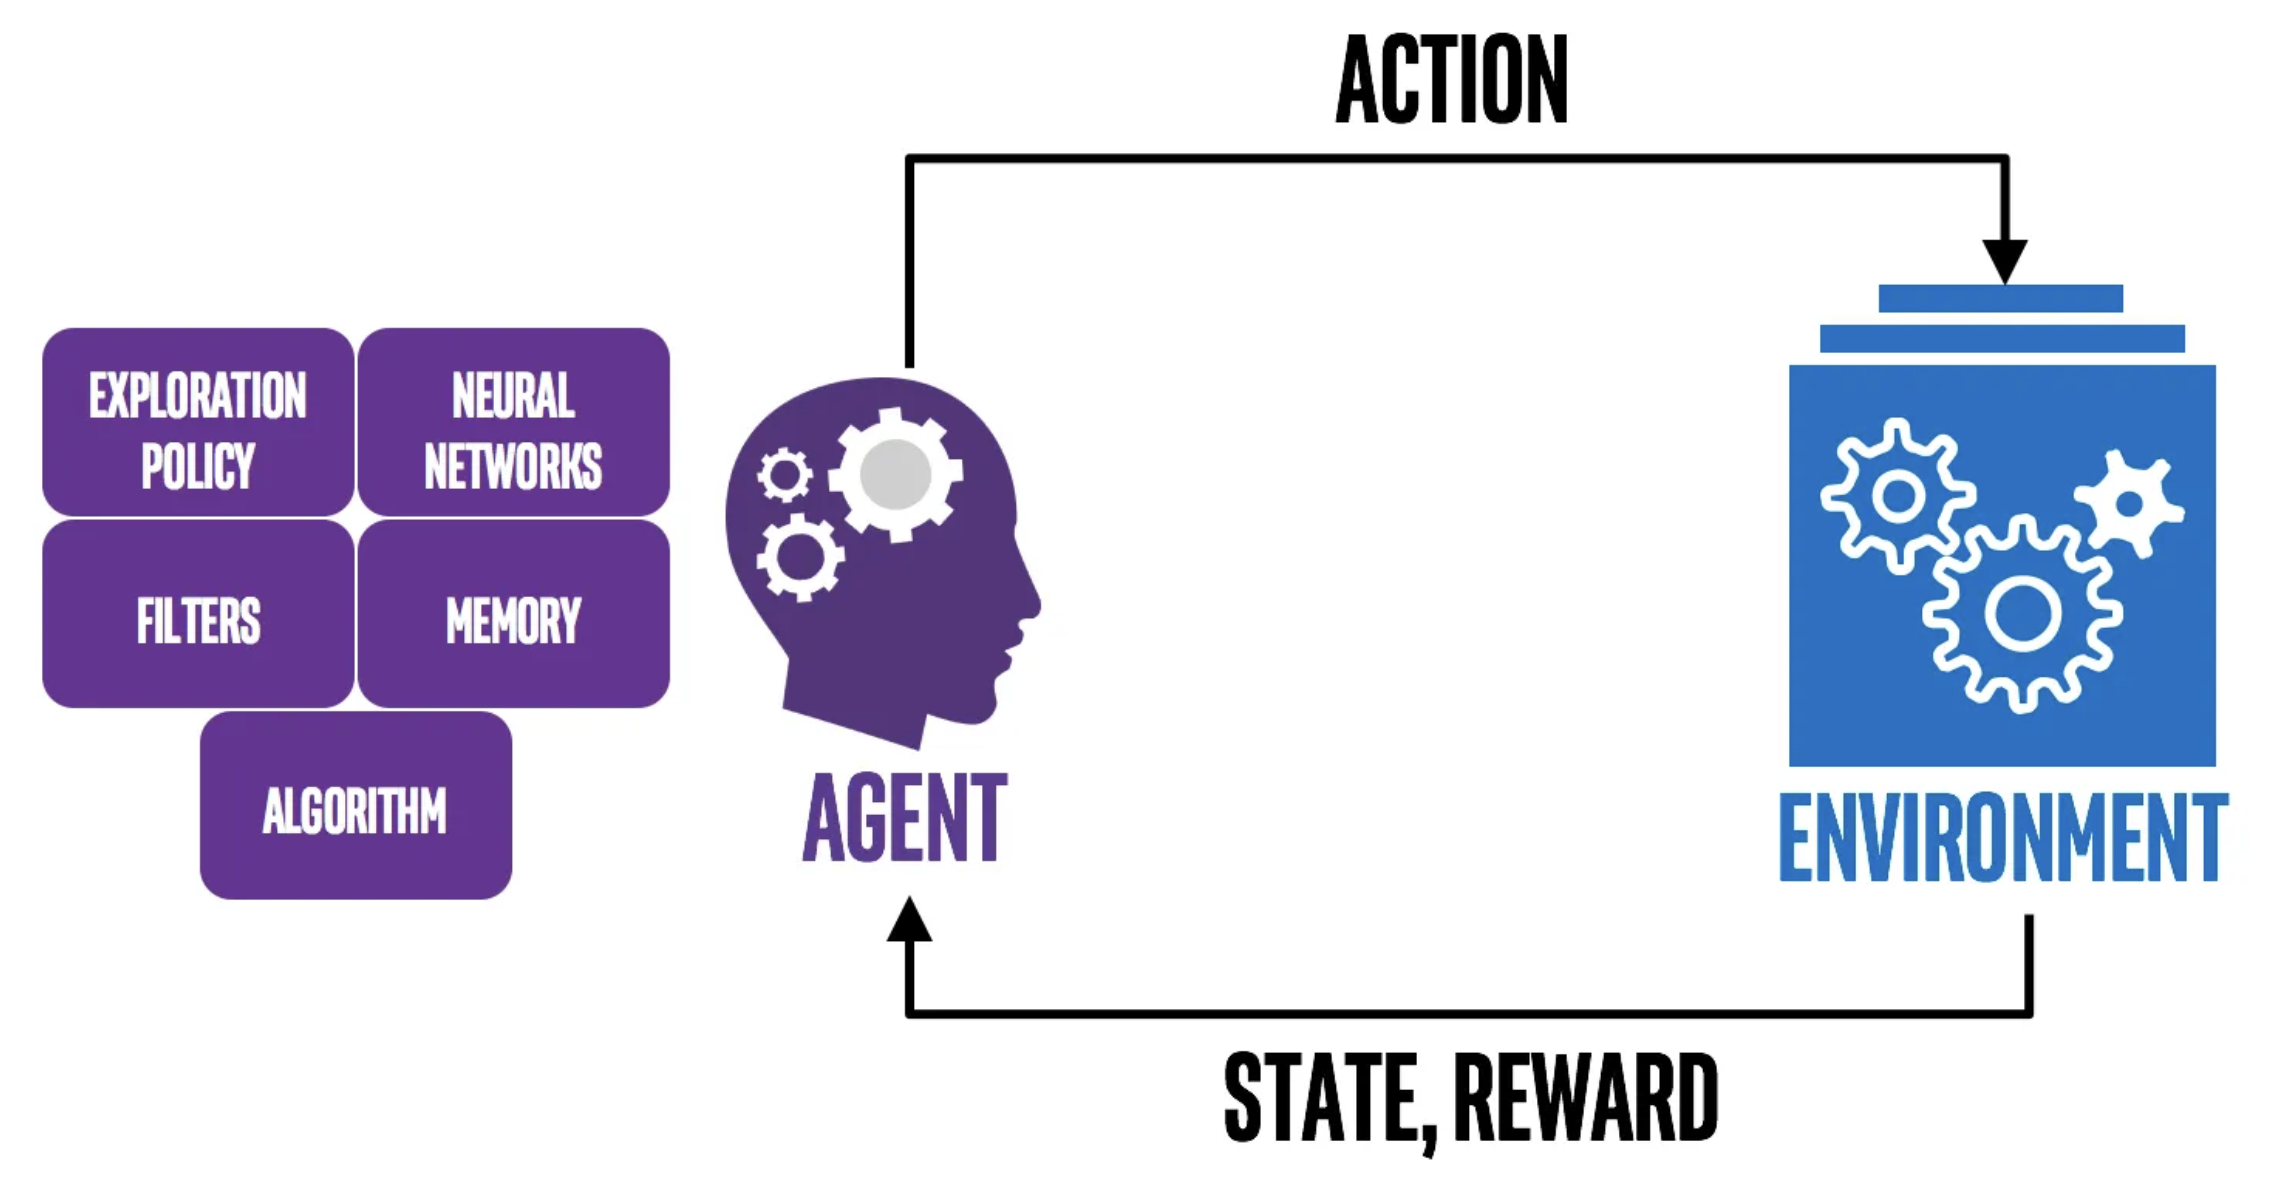

Reinforcement learning (RL) is an interdisciplinary area of machine learning and optimal control concerned with how an intelligent agent ought to take actions in a dynamic environment in order to maximize the cumulative reward. Reinforcement learning is one of three basic machine learning paradigms, alongside supervised learning and unsupervised learning.

In [1]:
import time

In [2]:
def print_time_execution(start, end, txt):

  delta = int(end - start)

  hours = int(delta/3_600)
  mins = int((delta - 3_600*hours)/60)
  segs = int(delta - hours*3600 - mins*60)

  return f'{txt} it takes {hours} hours, {mins} mins and {segs} segs.'

### Start time of execution

In [3]:
start = time.time()

# 1. Import Libraries

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import gym
import tqdm
import statistics
import collections
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from typing import Any, List, Sequence, Tuple

# 2. Load Environment

In [6]:
env = gym.make("CartPole-v0")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [7]:
seed = 42
env.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [8]:
eps = np.finfo(np.float32).eps.item()

# 3. Create Models

In [9]:
class ActorCritic(tf.keras.Model):

  def __init__(self, num_actions, num_hidden_units):

    super().__init__()

    self.common = layers.Dense(num_hidden_units, activation = "relu")
    self.actor = layers.Dense(num_actions)
    self.critic = layers.Dense(1)

  def call(self, inputs):

    x = self.common(inputs)

    return self.actor(x), self.critic(x)

In [10]:
num_actions = env.action_space.n
num_hidden_units = 128

In [11]:
model = ActorCritic(num_actions, num_hidden_units)

In [12]:
def env_step(action):

  state, reward, done, _ = env.step(action)

  return (state.astype(np.float32), np.array(reward, np.int32), np.array(done, np.int32))

In [13]:
def tf_env_step(action):

  return tf.numpy_function(env_step, [action], [tf.float32, tf.int32, tf.int32])

# 4. Run Episode

In [14]:
def run_episode(initial_state, model, max_steps):

  """Runs a single episode to collect training data."""

  action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

  initial_state_shape = initial_state.shape
  state = initial_state

  for t in tf.range(max_steps):

    # Convert state into a batched tensor (batch size = 1)
    state = tf.expand_dims(state, 0)

    # Run the model and to get action probabilities and critic value
    action_logits_t, value = model(state)

    # Sample next action from the action probability distribution
    action = tf.random.categorical(action_logits_t, 1)[0, 0]
    action_probs_t = tf.nn.softmax(action_logits_t)

    # Store critic values
    values = values.write(t, tf.squeeze(value))

    # Store log probability of the action chosen
    action_probs = action_probs.write(t, action_probs_t[0, action])

    # Apply action to the environment to get next state and reward
    state, reward, done = tf_env_step(action)
    state.set_shape(initial_state_shape)

    # Store reward
    rewards = rewards.write(t, reward)

    if tf.cast(done, tf.bool):
      break

  action_probs = action_probs.stack()
  values = values.stack()
  rewards = rewards.stack()

  return action_probs, values, rewards

In [15]:
def get_expected_return(rewards, gamma, standardize = True):
  """Compute expected returns per timestep."""

  n = tf.shape(rewards)[0]
  returns = tf.TensorArray(dtype=tf.float32, size=n)

  # Start from the end of `rewards` and accumulate reward sums
  # into the `returns` array
  rewards = tf.cast(rewards[::-1], dtype=tf.float32)

  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape

  for i in tf.range(n):

    reward = rewards[i]
    discounted_sum = reward + gamma * discounted_sum
    discounted_sum.set_shape(discounted_sum_shape)
    returns = returns.write(i, discounted_sum)

  returns = returns.stack()[::-1]

  if standardize:
    returns = ((returns - tf.math.reduce_mean(returns)) / (tf.math.reduce_std(returns) + eps))

  return returns

In [16]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

In [17]:
def compute_loss(action_probs, values, returns):

  """Computes the combined actor-critic loss."""

  advantage = returns - values

  action_log_probs = tf.math.log(action_probs)
  actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

  critic_loss = huber_loss(values, returns)

  return actor_loss + critic_loss

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)

In [19]:
@tf.function
def train_step(initial_state, model, optimizer, gamma, max_steps_per_episode):

  """Runs a model training step."""

  with tf.GradientTape() as tape:

    # Run the model for one episode to collect training data
    action_probs, values, rewards = run_episode(initial_state, model, max_steps_per_episode)

    # Calculate expected returns
    returns = get_expected_return(rewards, gamma)

    # Convert training data to appropriate TF tensor shapes
    action_probs, values, returns = [tf.expand_dims(x, 1) for x in [action_probs, values, returns]]

    # Calculating loss values to update our network
    loss = compute_loss(action_probs, values, returns)

  # Compute the gradients from the loss
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the model's parameters
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  episode_reward = tf.math.reduce_sum(rewards)

  return episode_reward

In [20]:
%%time

min_episodes_criterion = 100
max_episodes = 10_000
max_steps_per_episode = 1_000

# Cartpole-v0 is considered solved if average reward is >= 195 over 100
# consecutive trials
reward_threshold = 195
running_reward = 0

# Discount factor for future rewards
gamma = 0.99

# Keep last episodes reward
episodes_reward = collections.deque(maxlen = min_episodes_criterion)

all_episodes = []
all_rewards = []
all_last_rewards = []

with tqdm.trange(max_episodes) as t:

  for i in t:

    initial_state = tf.constant(env.reset(), dtype=tf.float32)
    episode_reward = int(train_step(initial_state, model, optimizer, gamma, max_steps_per_episode))

    episodes_reward.append(episode_reward)
    running_reward = statistics.mean(episodes_reward)

    t.set_description(f'Episode {i}')
    t.set_postfix(episode_reward = episode_reward, running_reward=running_reward)

    all_episodes.append(i)
    all_rewards.append(episode_reward)
    all_last_rewards.append(running_reward)

    # Show average episode reward every 10 episodes
    if i % 10 == 0:
      pass # print(f'Episode {i}: average reward: {avg_reward}')

    if running_reward > reward_threshold and i >= min_episodes_criterion:
        break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

Episode 644:   6%|▋         | 644/10000 [02:49<41:04,  3.80it/s, episode_reward=200, running_reward=195]


Solved at episode 644: average reward: 195.22!
CPU times: user 3min 24s, sys: 21.8 s, total: 3min 46s
Wall time: 2min 49s


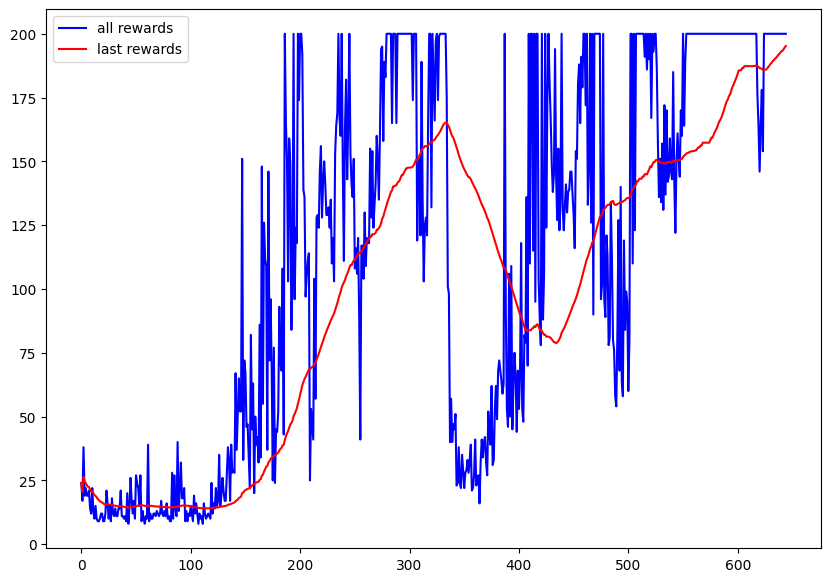

In [21]:
plt.figure(figsize = (10, 7))

plt.plot(all_episodes, all_rewards, color = 'blue', label = 'all rewards')
plt.plot(all_episodes, all_last_rewards, color = 'red', label = 'last rewards')

plt.legend()
plt.show()

# 5. Save GIF

In [22]:
from PIL import Image

In [23]:
def render_episode(env, model, max_steps):

  screen = env.render(mode = 'rgb_array')
  im = Image.fromarray(screen)

  images = [im]

  state = tf.constant(env.reset(), dtype=tf.float32)

  for i in range(1, max_steps + 1):

    state = tf.expand_dims(state, 0)
    action_probs, _ = model(state)
    action = np.argmax(np.squeeze(action_probs))

    state, _, done, _ = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    # Render screen every 10 steps

    if (i % 10) == 0:

      screen = env.render(mode = 'rgb_array')
      images.append(Image.fromarray(screen))

    if done:

      break

  return images

In [24]:
images = render_episode(env, model, max_steps_per_episode)
image_file = 'cartpole-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(image_file, save_all=True, append_images=images[1:], loop=0, duration=1)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [25]:
!pip install -q tensorflow_docs

In [26]:
import tensorflow_docs.vis.embed as embed


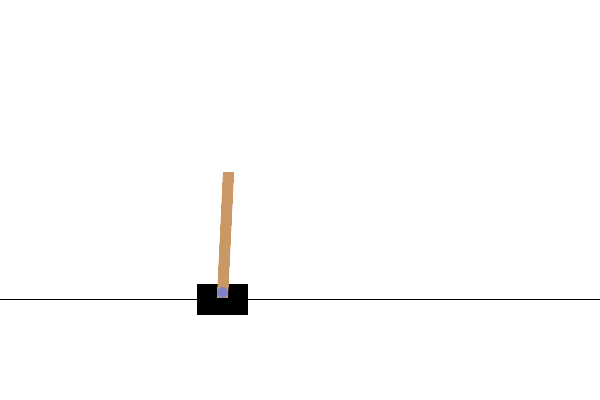

In [27]:
embed.embed_file(image_file)

### End time of execution

In [28]:
end = time.time()

In [29]:
print(print_time_execution(start, end, 'this notebook'))

this notebook it takes 0 hours, 3 mins and 4 segs.
